# 🔧 System Diagnostic - Run This First!

Before training, we need to verify that the GPU is properly accessible. This cell will check:
1. Slurm job allocation
2. GPU hardware detection
3. CUDA environment variables
4. PyTorch CUDA compatibility
5. Common issues and solutions

**Run the diagnostic cell below FIRST before proceeding with training!**

In [1]:
#!/usr/bin/env python3
"""Comprehensive GPU Diagnostic for HPC Cluster"""

import subprocess
import sys
import os

print("="*80)
print(" 🔍 COMPREHENSIVE GPU DIAGNOSTIC FOR HPC CLUSTER")
print("="*80)
print()

# 1. SLURM JOB INFORMATION
print("1️⃣  SLURM JOB ALLOCATION")
print("-" * 80)

slurm_vars = {
    'SLURM_JOB_ID': 'Job ID',
    'SLURM_JOB_NODELIST': 'Assigned Node(s)',
    'SLURM_GPUS_ON_NODE': 'GPUs on This Node',
}

for var, desc in slurm_vars.items():
    value = os.environ.get(var, 'NOT SET')
    print(f"  {desc:25s}: {value}")

# 2. GPU HARDWARE
print("\n2️⃣  GPU HARDWARE")
print("-" * 80)
try:
    result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], 
                          capture_output=True, text=True, timeout=5)
    if result.returncode == 0:
        print(f"  {result.stdout.strip()}")
except:
    print("  GPU info unavailable")

# 3. PYTORCH CUDA
print("\n3️⃣  PYTORCH CUDA")
print("-" * 80)
import torch
print(f"  PyTorch: {torch.__version__}")
print(f"  CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU Count: {torch.cuda.device_count()}")
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"  ✅ GPU Ready!")
else:
    print(f"  ❌ No GPU detected!")

print("\n" + "="*80)

 🔍 COMPREHENSIVE GPU DIAGNOSTIC FOR HPC CLUSTER

1️⃣  SLURM JOB ALLOCATION
--------------------------------------------------------------------------------
  Job ID                   : 3030862
  Assigned Node(s)         : gpu8
  GPUs on This Node        : 1

2️⃣  GPU HARDWARE
--------------------------------------------------------------------------------
  NVIDIA A100 80GB PCIe, 80994 MiB

3️⃣  PYTORCH CUDA
--------------------------------------------------------------------------------
  PyTorch: 2.7.1+cu118
  CUDA Available: True
  GPU Count: 1
  GPU Name: NVIDIA A100 80GB PCIe
  ✅ GPU Ready!



# Train Unconditional UNet2D on ImageNet with VAE

This notebook trains an **unconditional** diffusion model on ImageNet using:
- **Pretrained VAE** (AutoencoderKL from Stable Diffusion) to encode images to latents
- **UNet2DModel** (unconditional, no cross-attention)
- **DDPM scheduler** for training and inference

## ⚠️ ImageNet Dataset Information

**Important Notes:**
- ImageNet is VERY LARGE (~150GB training set, 1.2M images)
- Requires manual download and extraction
- This notebook uses **ImageNet-1K** (ILSVRC2012)
- You need to obtain ImageNet from [image-net.org](https://image-net.org/download.php)

## Dataset Setup Options

### Option 1: Full ImageNet (Recommended for Research)
- Download ILSVRC2012 training set
- Extract to `../../datasets/imagenet/train/`
- 1000 classes, ~1.2M images

### Option 2: ImageNet Subset (For Testing)
- Use `torchvision.datasets.ImageNet` with subset
- Or download "Tiny ImageNet" (200 classes, 100K images)
- Faster to download and train

### Option 3: Use HuggingFace Datasets
```python
from datasets import load_dataset
dataset = load_dataset("imagenet-1k", split="train", streaming=True)
```

## Key Design Choices
- ImageNet images resized to 256x256
- Images normalized to [-1,1] for VAE compatibility  
- VAE encodes to 32x32x4 latents
- Only the UNet is trained; VAE is frozen
- **Unconditional generation** - no class labels used

## Memory Optimizations
- **Batch size**: 16 (adjust based on GPU memory)
- **Image size**: 256x256
- **Mixed precision**: FP16
- **Streaming**: Load images on-the-fly
- **Cache clearing**: Periodic GPU cache clearing

# 🎨 ImageNet Unconditional Diffusion Model Training

## What's Different from CelebA (train10)?

1. **Dataset**: ImageNet (1.2M diverse objects) vs CelebA (200K faces)
2. **Image Variety**: 1000 object categories vs single domain (faces)
3. **Dataset Size**: Much larger - requires careful memory management
4. **Download**: Manual download required (registration needed)
5. **Training Time**: Significantly longer due to dataset size

## Quick Start

1. **Download ImageNet** (see instructions below)
2. Run diagnostic cell to verify GPU
3. Configure dataset path
4. Start training - checkpoints every 2000 steps
5. Monitor progress through sample images

## 📥 ImageNet Download Instructions

### Manual Download (Official)
1. Register at [image-net.org](https://image-net.org/download.php)
2. Download ILSVRC2012 training images
3. Extract to: `../../datasets/imagenet/`
4. Expected structure:
   ```
   datasets/imagenet/
   ├── train/
   │   ├── n01440764/  (class folder)
   │   │   ├── image1.JPEG
   │   │   └── ...
   │   └── .../
   └── val/  (optional)
   ```

### Alternative: Kaggle ImageNet
1. Install Kaggle CLI: `pip install kaggle`
2. Setup API token: `~/.kaggle/kaggle.json`
3. Download: `kaggle competitions download -c imagenet-object-localization-challenge`

### Alternative: HuggingFace Dataset (Easiest)
Uses streaming to avoid downloading full dataset:
```python
from datasets import load_dataset
ds = load_dataset("imagenet-1k", split="train", streaming=True)
```

**Note**: Full download is ~150GB. Make sure you have enough disk space!

## 1. Imports and Setup

In [2]:
from __future__ import annotations

import os
import math
from dataclasses import dataclass
from typing import List, Optional

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from diffusers import DDPMScheduler
from diffusers.models import AutoencoderKL, UNet2DModel

/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Helper Functions

In [3]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def build_transforms(image_size: int = 256) -> transforms.Compose:
    """Transform ImageNet images: resize, normalize to [-1,1] for VAE."""
    return transforms.Compose(
        [
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )


def seed_everything(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

## 3. Configuration

In [4]:
@dataclass
class TrainConfig:
    dataset_root: str
    output_dir: str = "./outputs/train11_imagenet"
    batch_size: int = 16
    num_epochs: int = 100  # 100 epochs for extensive training
    lr: float = 1e-4
    num_train_timesteps: int = 1000
    image_size: int = 256
    seed: int = 42
    mixed_precision: bool = True
    checkpoint_interval: int = 2000
    # UNet size for ImageNet (diverse objects)
    unet_block_out_channels: tuple[int, ...] = (128, 256, 512, 512)
    layers_per_block: int = 2
    # ImageNet specific
    use_huggingface: bool = True  # Use HF datasets with streaming
    max_train_samples: Optional[int] = None  # Limit samples for testing (None = all)


# Configure training parameters
config = TrainConfig(
    dataset_root="../../datasets/imagenet",  # Local path if downloaded
    output_dir="./outputs/train11_imagenet",
    batch_size=16,  # Adjust based on GPU memory
    num_epochs=100,  # 100 epochs for extensive training
    lr=1e-4,
    image_size=256,
    mixed_precision=True,
    checkpoint_interval=2000,
    use_huggingface=True,  # Set to False if using local ImageNet
    max_train_samples=None,  # Set to e.g. 50000 for faster testing
)

print(f"Device: {get_device()}")
print(f"Batch size: {config.batch_size}")
print(f"Epochs: {config.num_epochs}")
print(f"Learning rate: {config.lr}")
print(f"Image size: {config.image_size}")
print(f"Output directory: {config.output_dir}")
print(f"Mixed precision: {config.mixed_precision}")
print(f"Checkpoint interval: {config.checkpoint_interval} steps")
print(f"Using HuggingFace datasets: {config.use_huggingface}")
if config.max_train_samples:
    print(f"⚠️  Training on subset: {config.max_train_samples} samples")
print(f"\nDataset: ImageNet-1K (Unconditional Generation)")

Device: cuda
Batch size: 16
Epochs: 100
Learning rate: 0.0001
Image size: 256
Output directory: ./outputs/train11_imagenet
Mixed precision: True
Checkpoint interval: 2000 steps
Using HuggingFace datasets: True

Dataset: ImageNet-1K (Unconditional Generation)


## 4. Load Models

In [5]:
def create_models(device: torch.device, config: TrainConfig):
    # Pretrained VAE
    print("Loading pretrained VAE...")
    vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
    vae.requires_grad_(False)
    vae.eval()
    vae.to(device)

    print("Creating UNet2DModel (unconditional)...")
    # Unconditional UNet for diverse ImageNet objects
    unet = UNet2DModel(
        sample_size=config.image_size // 8,  # 32 for 256x256
        in_channels=4,
        out_channels=4,
        layers_per_block=config.layers_per_block,
        block_out_channels=config.unet_block_out_channels,
        down_block_types=(
            "DownBlock2D",
            "AttnDownBlock2D",
            "AttnDownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",
            "AttnUpBlock2D",
            "AttnUpBlock2D",
            "UpBlock2D",
        ),
    ).to(device)

    num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f"UNet trainable parameters: {num_params:,}")

    return vae, unet


# Initialize models
device = get_device()
seed_everything(config.seed)
vae, unet = create_models(device, config)

Loading pretrained VAE...
Creating UNet2DModel (unconditional)...
UNet trainable parameters: 102,442,500


## 5. Prepare ImageNet Dataset

This section provides two methods:
1. **HuggingFace Datasets** (streaming, no download)
2. **Local ImageNet** (requires manual download)

## 5a. Dataset Options

**ImageNet datasets on HuggingFace are GATED and require authentication.**

Since ImageNet requires authentication, we have several options:

### Option 1: Use Local ImageNet (Recommended if you have it)
Set `config.use_huggingface = False` and provide local path

### Option 2: Use Alternative Large-Scale Dataset (No Auth Required)
We'll use **Food-101** dataset as an alternative:
- 101 food categories
- 101,000 images
- No authentication required
- Good for testing diffusion models on diverse real-world images

### Option 3: Authenticate with HuggingFace
If you have ImageNet access, authenticate first:
```bash
# In terminal, not in notebook:
huggingface-cli login
```
Then restart the kernel and the dataset will load.

**For this notebook, we'll use Food-101 by default** (no auth needed).

## 5b. How to Use ImageNet (Optional)

If you want to use the actual ImageNet dataset instead of Food-101:

### Step 1: Get ImageNet Access
1. Visit [https://huggingface.co/datasets/ILSVRC/imagenet-1k](https://huggingface.co/datasets/ILSVRC/imagenet-1k)
2. Click "Request Access" and accept terms
3. Wait for approval (usually instant)

### Step 2: Authenticate
Run in a **terminal** (not in notebook):
```bash
huggingface-cli login
```
Enter your HuggingFace token from [https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)

### Step 3: Modify Dataset Name
In the `make_dataloader_huggingface` function below, change:
```python
dataset_name = "food101"  # Change this line to:
dataset_name = "ILSVRC/imagenet-1k"
```

Then restart the kernel and run the notebook.

In [6]:
def make_dataloader_huggingface(config: TrainConfig) -> DataLoader:
    """Load ImageNet using HuggingFace datasets with streaming."""
    from datasets import load_dataset
    from torch.utils.data import IterableDataset
    
    print("Loading dataset from HuggingFace (streaming mode)...")
    
    # ImageNet is gated - using Food-101 as alternative (no auth required)
    # To use ImageNet instead: authenticate with `huggingface-cli login` first
    dataset_name = "food101"  # Change to "ILSVRC/imagenet-1k" if authenticated
    
    print(f"Using dataset: {dataset_name}")
    print("⚠️  Note: ImageNet requires authentication. Using Food-101 instead.")
    print("   To use ImageNet: Run 'huggingface-cli login' in terminal first.")
    
    try:
        ds = load_dataset(
            dataset_name,
            split="train",
            streaming=True,
            trust_remote_code=True
        )
        print("✅ Dataset loaded successfully!")
    except Exception as e:
        print(f"\n❌ Error loading dataset: {e}")
        print("\n🔧 Solutions:")
        print("1. Check your internet connection")
        print("2. Authenticate with HuggingFace: huggingface-cli login")
        print("3. OR set config.use_huggingface=False and use local ImageNet")
        raise
    
    # Apply transforms
    tfms = build_transforms(config.image_size)
    
    class ImageNetStreamDataset(IterableDataset):
        def __init__(self, hf_dataset, transform, max_samples=None):
            self.dataset = hf_dataset
            self.transform = transform
            self.max_samples = max_samples
            
        def __iter__(self):
            count = 0
            for example in self.dataset:
                if self.max_samples and count >= self.max_samples:
                    break
                # Get image from example
                image = example['image']
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                image = self.transform(image)
                yield image
                count += 1
    
    dataset = ImageNetStreamDataset(ds, tfms, config.max_train_samples)
    
    return DataLoader(
        dataset,
        batch_size=config.batch_size,
        num_workers=2,
        pin_memory=True
    )


def make_dataloader_local(config: TrainConfig) -> DataLoader:
    """Load ImageNet from local directory."""
    print(f"Loading ImageNet from local path: {config.dataset_root}")
    
    tfms = build_transforms(config.image_size)
    
    # Check if dataset exists
    train_dir = os.path.join(config.dataset_root, 'train')
    if not os.path.exists(train_dir):
        raise FileNotFoundError(
            f"ImageNet training directory not found: {train_dir}\n"
            f"Please download ImageNet and extract to {config.dataset_root}/\n"
            f"Or set config.use_huggingface=True to use streaming."
        )
    
    ds = datasets.ImageFolder(root=train_dir, transform=tfms)
    
    # Optionally limit dataset size
    if config.max_train_samples:
        from torch.utils.data import Subset
        indices = list(range(min(config.max_train_samples, len(ds))))
        ds = Subset(ds, indices)
    
    return DataLoader(
        ds,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )


# Create dataloader based on configuration
if config.use_huggingface:
    print("⚠️  Using HuggingFace streaming dataset (may be slower but no download needed)")
    dataloader = make_dataloader_huggingface(config)
    print("Dataset loaded in streaming mode")
else:
    dataloader = make_dataloader_local(config)
    print(f"Dataset size: {len(dataloader.dataset)}")
    print(f"Number of batches: {len(dataloader)}")

⚠️  Using HuggingFace streaming dataset (may be slower but no download needed)


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'food101' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading dataset from HuggingFace (streaming mode)...
Using dataset: food101
⚠️  Note: ImageNet requires authentication. Using Food-101 instead.
   To use ImageNet: Run 'huggingface-cli login' in terminal first.
✅ Dataset loaded successfully!
Dataset loaded in streaming mode


## 6. Visualize Sample Data

Loading sample batch...
Batch shape: torch.Size([16, 3, 256, 256])


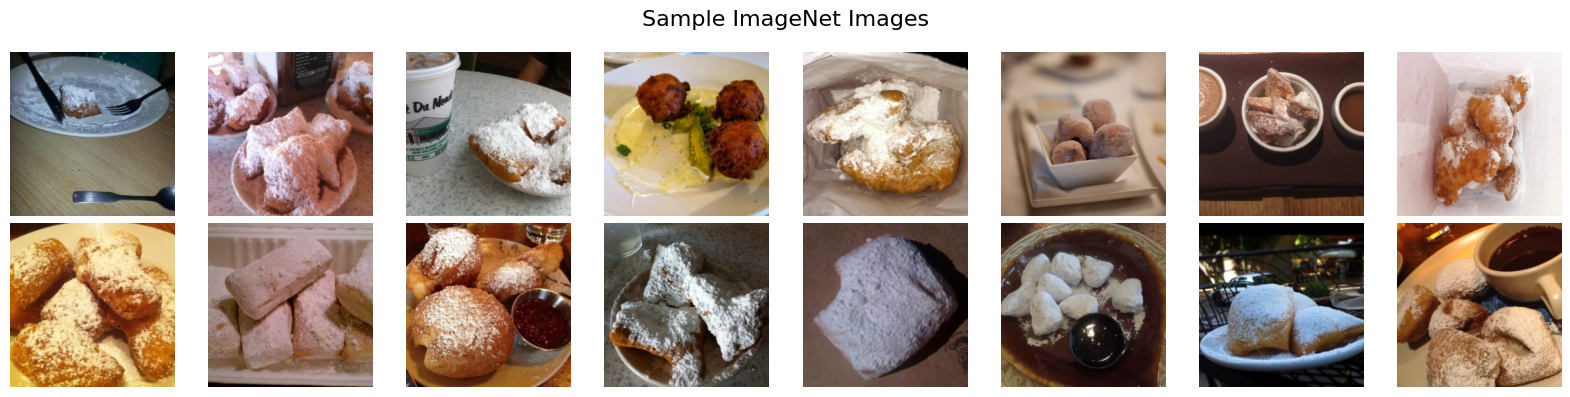

In [7]:
# Visualize a batch
print("Loading sample batch...")
sample_iter = iter(dataloader)
sample_batch = next(sample_iter)

# Handle different batch formats
if isinstance(sample_batch, (list, tuple)):
    sample_images = sample_batch[0]
else:
    sample_images = sample_batch

print(f"Batch shape: {sample_images.shape}")

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    if i < len(sample_images):
        img = sample_images[i].permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
        ax.imshow(img)
        ax.axis('off')
plt.suptitle("Sample ImageNet Images", fontsize=16)
plt.tight_layout()
plt.show()

del sample_iter, sample_batch, sample_images
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## 7. Checkpoint Management Functions

In [8]:
def find_latest_checkpoint(output_dir: str):
    """Find the latest checkpoint in the output directory."""
    if not os.path.exists(output_dir):
        return None
    
    checkpoint_files = []
    for filename in os.listdir(output_dir):
        if filename.endswith('.pt') and (filename.startswith('unet_step_') or filename.startswith('unet_epoch_')):
            filepath = os.path.join(output_dir, filename)
            checkpoint_files.append(filepath)
    
    if not checkpoint_files:
        return None
    
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    return latest_checkpoint


def load_checkpoint(checkpoint_path: str, unet, optimizer=None):
    """Load checkpoint and return metadata."""
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    if isinstance(checkpoint, dict):
        if 'unet' in checkpoint:
            unet.load_state_dict(checkpoint['unet'])
        else:
            unet.load_state_dict(checkpoint)
        
        if optimizer is not None and 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        
        metadata = {
            'global_step': checkpoint.get('global_step', checkpoint.get('step', 0)),
            'epoch': checkpoint.get('epoch', 0),
            'batch_losses': checkpoint.get('batch_losses', []),
            'epoch_losses': checkpoint.get('epoch_losses', []),
        }
    else:
        unet.load_state_dict(checkpoint)
        metadata = {'global_step': 0, 'epoch': 0, 'batch_losses': [], 'epoch_losses': []}
    
    print(f"Resumed from step {metadata['global_step']}, epoch {metadata['epoch']}")
    return metadata


def save_checkpoint(path: str, unet, optimizer, global_step: int, epoch: int, 
                   batch_losses: List[float], epoch_losses: List[float]):
    """Save checkpoint with complete metadata."""
    checkpoint = {
        'unet': unet.state_dict(),
        'optimizer': optimizer.state_dict(),
        'global_step': global_step,
        'epoch': epoch,
        'batch_losses': batch_losses,
        'epoch_losses': epoch_losses,
    }
    torch.save(checkpoint, path)

### Checkpoint System Features

The checkpoint system provides:

1. **Automatic Resume**: Detects and loads the latest checkpoint automatically
2. **Complete Metadata**: Stores model weights, optimizer state, step count, losses
3. **Training Plots**: Loss plots saved with every checkpoint
4. **Sample Images**: Generated ImageNet samples at each checkpoint
5. **Multiple Checkpoint Types**:
   - Step checkpoints: `unet_step_2000.pt`
   - Epoch checkpoints: `unet_epoch_1.pt`
   - Final checkpoint: `unet_final.pt`
   - Sample images: `samples_step_2000.png`

**Important for ImageNet**: Due to the massive dataset size, checkpoints are crucial for resuming training!

In [11]:
latest_checkpoint = find_latest_checkpoint(config.output_dir)
if latest_checkpoint:
    print(f"✅ Found existing checkpoint: {latest_checkpoint}")
    print("=" * 80)
    print("🔍 VALIDATING CHECKPOINT BEFORE RESUMING TRAINING")
    print("=" * 80)
    
    print("\nLoading checkpoint for validation...")
    temp_metadata = load_checkpoint(latest_checkpoint, unet, None)
    
    print(f"\n📊 Checkpoint Information:")
    print(f"   Global Step: {temp_metadata['global_step']:,}")
    print(f"   Epoch: {temp_metadata['epoch']}")
    print(f"   Batch Losses Recorded: {len(temp_metadata['batch_losses']):,}")
    print(f"   Epoch Losses Recorded: {len(temp_metadata['epoch_losses'])}")
    
    if temp_metadata['batch_losses']:
        recent_losses = temp_metadata['batch_losses'][-100:]
        print(f"   Recent Avg Loss (last 100 batches): {sum(recent_losses)/len(recent_losses):.4f}")
    
    print(f"\n🎨 Generating test samples from checkpoint...")
    validation_samples_path = os.path.join(config.output_dir, f"checkpoint_validation_step_{temp_metadata['global_step']}.png")
    
    generate_checkpoint_samples(
        unet, vae, device, config,
        save_path=validation_samples_path,
        global_step=temp_metadata['global_step'],
        num_samples=16,
        num_inference_steps=50
    )
    
    print(f"✅ Checkpoint validation complete!")
    print(f"   Validation samples saved: {validation_samples_path}")
    print(f"\n▶️  Training will resume from step {temp_metadata['global_step']}, epoch {temp_metadata['epoch']}")
    print(f"   Next checkpoint will be saved at step {((temp_metadata['global_step'] // config.checkpoint_interval) + 1) * config.checkpoint_interval}")
    print("=" * 80)
else:
    print("No existing checkpoints found. Starting training from scratch.")

✅ Found existing checkpoint: ./outputs/train11_imagenet/unet_epoch_5.pt
🔍 VALIDATING CHECKPOINT BEFORE RESUMING TRAINING

Loading checkpoint for validation...
Loading checkpoint from: ./outputs/train11_imagenet/unet_epoch_5.pt
Resumed from step 23680, epoch 5

📊 Checkpoint Information:
   Global Step: 23,680
   Epoch: 5
   Batch Losses Recorded: 23,680
   Epoch Losses Recorded: 5
   Recent Avg Loss (last 100 batches): 0.2895

🎨 Generating test samples from checkpoint...

Generating 16 samples at step 23680...
Sample images saved: ./outputs/train11_imagenet/checkpoint_validation_step_23680.png
✅ Checkpoint validation complete!
   Validation samples saved: ./outputs/train11_imagenet/checkpoint_validation_step_23680.png

▶️  Training will resume from step 23680, epoch 5
   Next checkpoint will be saved at step 24000


## 7b. Checkpoint Validation - IMPORTANT!

**Before resuming training**, we validate the checkpoint by:
1. Loading the checkpoint
2. Displaying metadata (step, epoch, loss history)
3. Generating test images to verify the model works
4. Only then proceed with training

This ensures the checkpoint is valid and the model is working correctly!

## 8. Sample Generation Function

In [10]:
def generate_checkpoint_samples(
    unet, vae, device, config, 
    save_path: str, global_step: int, num_samples: int = 16, num_inference_steps: int = 50
):
    """Generate sample images during training checkpoints (unconditional)."""
    print(f"\nGenerating {num_samples} samples at step {global_step}...")
    
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)
    
    unet.eval()
    
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    
    with torch.no_grad():
        for i, ax in enumerate(axes.flat):
            if i >= num_samples:
                ax.axis('off')
                continue
                
            torch.manual_seed(42 + i)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(42 + i)
            
            latents = torch.randn((1, 4, config.image_size // 8, config.image_size // 8), device=device)
            
            for t in scheduler.timesteps:
                latent_model_input = scheduler.scale_model_input(latents, t)
                noise_pred = unet(latent_model_input, t).sample
                latents = scheduler.step(noise_pred, t, latents).prev_sample
            
            latents = latents / 0.18215
            image = vae.decode(latents).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.detach().cpu()
            
            img = image[0].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')
    
    plt.suptitle(f"Generated Samples at Step {global_step}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Sample images saved: {save_path}")
    
    unet.train()

## 9. Training Loop

In [12]:
def train(config: TrainConfig, vae, unet, dataloader, device, resume_from_checkpoint: str = None):
    os.makedirs(config.output_dir, exist_ok=True)

    noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_train_timesteps, beta_schedule="squaredcos_cap_v2")
    optimizer = torch.optim.AdamW(unet.parameters(), lr=config.lr)
    scaler = torch.cuda.amp.GradScaler(enabled=config.mixed_precision and device.type == "cuda")

    batch_losses = []
    epoch_losses = []
    global_step = 0
    start_epoch = 0
    
    if resume_from_checkpoint:
        metadata = load_checkpoint(resume_from_checkpoint, unet, optimizer)
        global_step = metadata['global_step']
        start_epoch = metadata['epoch']
        batch_losses = metadata['batch_losses']
        epoch_losses = metadata['epoch_losses']

    unet.train()
    
    for epoch in range(start_epoch, config.num_epochs):
        epoch_loss_sum = 0.0
        epoch_batch_count = 0
        
        # For streaming datasets, we can't get total length
        desc = f"Epoch {epoch+1}/{config.num_epochs}"
        pbar = tqdm(dataloader, desc=desc)
        
        for batch_idx, batch in enumerate(pbar):
            # Handle different batch formats
            if isinstance(batch, (list, tuple)):
                images = batch[0]
            else:
                images = batch
                
            images = images.to(device, non_blocking=True)

            with torch.no_grad():
                latents = vae.encode(images).latent_dist.sample() * 0.18215

            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            with torch.autocast(
                device_type=device.type,
                dtype=torch.float16 if (config.mixed_precision and device.type == "cuda") else torch.float32,
                enabled=config.mixed_precision
            ):
                noise_pred = unet(noisy_latents, timesteps).sample
                loss = nn.functional.mse_loss(noise_pred, noise)

            optimizer.zero_grad(set_to_none=True)
            if scaler.is_enabled():
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            loss_value = loss.item()
            batch_losses.append(loss_value)
            epoch_loss_sum += loss_value
            epoch_batch_count += 1

            global_step += 1
            pbar.set_postfix({"loss": f"{loss_value:.4f}", "step": global_step})

            if batch_idx % 50 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Save periodic checkpoints
            if global_step % config.checkpoint_interval == 0:
                ckpt_path = os.path.join(config.output_dir, f"unet_step_{global_step}.pt")
                save_checkpoint(ckpt_path, unet, optimizer, global_step, epoch, batch_losses, epoch_losses)
                print(f"\nCheckpoint saved: {ckpt_path}")
                
                plot_path = os.path.join(config.output_dir, f"training_loss_step_{global_step}.png")
                save_loss_plot(batch_losses, epoch_losses, plot_path)
                print(f"Training plot saved: {plot_path}")
                
                samples_path = os.path.join(config.output_dir, f"samples_step_{global_step}.png")
                generate_checkpoint_samples(unet, vae, device, config, save_path=samples_path, global_step=global_step)
                
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        avg_epoch_loss = epoch_loss_sum / epoch_batch_count if epoch_batch_count > 0 else 0.0
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}/{config.num_epochs} - Average Loss: {avg_epoch_loss:.4f}")

        ckpt_path = os.path.join(config.output_dir, f"unet_epoch_{epoch+1}.pt")
        save_checkpoint(ckpt_path, unet, optimizer, global_step, epoch + 1, batch_losses, epoch_losses)
        
        plot_path = os.path.join(config.output_dir, f"training_loss_epoch_{epoch+1}.png")
        save_loss_plot(batch_losses, epoch_losses, plot_path)
        
        samples_path = os.path.join(config.output_dir, f"samples_epoch_{epoch+1}.png")
        generate_checkpoint_samples(unet, vae, device, config, save_path=samples_path, global_step=global_step)
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    final_path = os.path.join(config.output_dir, "unet_final.pt")
    save_checkpoint(final_path, unet, optimizer, global_step, config.num_epochs, batch_losses, epoch_losses)
    print(f"\nFinal model saved: {final_path}")
    
    final_plot_path = os.path.join(config.output_dir, "training_loss_final.png")
    save_loss_plot(batch_losses, epoch_losses, final_plot_path)
    
    final_samples_path = os.path.join(config.output_dir, "samples_final.png")
    generate_checkpoint_samples(unet, vae, device, config, save_path=final_samples_path, global_step=global_step)

    return batch_losses, epoch_losses


def save_loss_plot(batch_losses: List[float], epoch_losses: List[float], save_path: str):
    """Helper function to save loss plots without displaying them."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    if len(batch_losses) > 0:
        axes[0].plot(batch_losses, linewidth=0.8, alpha=0.7)
        axes[0].set_xlabel("Batch")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Training Loss per Batch")
        axes[0].grid(True, alpha=0.3)

    if len(epoch_losses) > 0:
        axes[1].plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linewidth=2)
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Average Loss")
        axes[1].set_title("Training Loss per Epoch")
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close(fig)

## 10. Memory Optimization (Clear GPU Cache)

In [13]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    import os
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU Memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    print("Memory cache cleared and optimized for training")

GPU Memory allocated: 0.71 GB
GPU Memory reserved: 0.76 GB
Memory cache cleared and optimized for training


## 11. Run Training

**⚠️ Important Notes for ImageNet Training:**

1. **Training Time**: ImageNet is MASSIVE. Even one epoch can take days on a single GPU.
2. **Checkpoints**: Make sure to save checkpoints frequently (already configured every 2000 steps).
3. **Monitoring**: Check sample images at each checkpoint to monitor progress.
4. **Resources**: Consider using multiple GPUs or distributed training for faster training.
5. **Subset Training**: For initial testing, set `config.max_train_samples` to a smaller number (e.g., 50000).

Loading checkpoint from: ./outputs/train11_imagenet/unet_epoch_5.pt


/tmp/ipykernel_552657/322448537.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=config.mixed_precision and device.type == "cuda")


Resumed from step 23680, epoch 5


Epoch 6/100: 319it [00:44,  7.90it/s, loss=0.3974, step=24000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_24000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_24000.png

Generating 16 samples at step 24000...


Epoch 6/100: 321it [01:04,  4.20s/it, loss=0.3893, step=24001]

Sample images saved: ./outputs/train11_imagenet/samples_step_24000.png


Epoch 6/100: 1391it [03:22,  7.75it/s, loss=0.3162, step=25071]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 6/100: 2319it [05:21,  7.64it/s, loss=0.2529, step=26000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_26000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_26000.png

Generating 16 samples at step 26000...


Epoch 6/100: 2321it [05:41,  4.15s/it, loss=0.4015, step=26001]

Sample images saved: ./outputs/train11_imagenet/samples_step_26000.png


Epoch 6/100: 4319it [10:01,  7.88it/s, loss=0.2537, step=28000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_28000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_28000.png

Generating 16 samples at step 28000...


Epoch 6/100: 4321it [10:20,  4.08s/it, loss=0.3798, step=28001]

Sample images saved: ./outputs/train11_imagenet/samples_step_28000.png


Epoch 6/100: 4736it [11:13,  7.03it/s, loss=0.2857, step=28416]


Epoch 6/100 - Average Loss: 0.2954

Generating 16 samples at step 28416...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_6.png


Epoch 7/100: 1391it [03:05,  7.82it/s, loss=0.2037, step=29807]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 7/100: 1583it [03:29,  7.87it/s, loss=0.2346, step=3e+4] 


Checkpoint saved: ./outputs/train11_imagenet/unet_step_30000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_30000.png

Generating 16 samples at step 30000...


Epoch 7/100: 1585it [03:48,  4.10s/it, loss=0.3677, step=3e+4]

Sample images saved: ./outputs/train11_imagenet/samples_step_30000.png


Epoch 7/100: 3583it [08:09,  7.51it/s, loss=0.2430, step=32000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_32000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_32000.png

Generating 16 samples at step 32000...


Epoch 7/100: 3585it [08:28,  4.11s/it, loss=0.4048, step=32001]

Sample images saved: ./outputs/train11_imagenet/samples_step_32000.png


Epoch 7/100: 4736it [10:56,  7.21it/s, loss=0.3576, step=33152]


Epoch 7/100 - Average Loss: 0.2934

Generating 16 samples at step 33152...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_7.png


Epoch 8/100: 847it [01:53,  7.76it/s, loss=0.2993, step=34000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_34000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_34000.png

Generating 16 samples at step 34000...


Epoch 8/100: 849it [02:12,  4.18s/it, loss=0.3664, step=34001]

Sample images saved: ./outputs/train11_imagenet/samples_step_34000.png


Epoch 8/100: 1391it [03:24,  7.85it/s, loss=0.2285, step=34543]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 8/100: 2847it [06:33,  7.78it/s, loss=0.2568, step=36000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_36000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_36000.png

Generating 16 samples at step 36000...


Epoch 8/100: 2849it [06:53,  4.19s/it, loss=0.3770, step=36001]

Sample images saved: ./outputs/train11_imagenet/samples_step_36000.png


Epoch 8/100: 4736it [10:57,  7.20it/s, loss=0.1036, step=37888]


Epoch 8/100 - Average Loss: 0.2929

Generating 16 samples at step 37888...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_8.png


Epoch 9/100: 111it [00:18,  7.70it/s, loss=0.2559, step=38000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_38000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_38000.png

Generating 16 samples at step 38000...


Epoch 9/100: 113it [00:37,  4.11s/it, loss=0.3819, step=38001]

Sample images saved: ./outputs/train11_imagenet/samples_step_38000.png


Epoch 9/100: 1391it [03:23,  7.78it/s, loss=0.2424, step=39279]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 9/100: 2111it [04:56,  7.80it/s, loss=0.2570, step=4e+4] 


Checkpoint saved: ./outputs/train11_imagenet/unet_step_40000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_40000.png

Generating 16 samples at step 40000...


Epoch 9/100: 2113it [05:16,  4.26s/it, loss=0.3680, step=4e+4]

Sample images saved: ./outputs/train11_imagenet/samples_step_40000.png


Epoch 9/100: 4111it [09:36,  7.75it/s, loss=0.2615, step=42000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_42000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_42000.png

Generating 16 samples at step 42000...


Epoch 9/100: 4113it [09:55,  4.10s/it, loss=0.3737, step=42001]

Sample images saved: ./outputs/train11_imagenet/samples_step_42000.png


Epoch 9/100: 4736it [11:15,  7.01it/s, loss=0.2190, step=42624]


Epoch 9/100 - Average Loss: 0.2923

Generating 16 samples at step 42624...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_9.png


Epoch 10/100: 1375it [03:03,  7.89it/s, loss=0.4376, step=44000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_44000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_44000.png

Generating 16 samples at step 44000...


Epoch 10/100: 1377it [03:22,  4.15s/it, loss=0.4033, step=44001]

Sample images saved: ./outputs/train11_imagenet/samples_step_44000.png


Epoch 10/100: 1391it [03:24,  6.48it/s, loss=0.3837, step=44015]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 10/100: 3375it [07:41,  7.77it/s, loss=0.2401, step=46000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_46000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_46000.png

Generating 16 samples at step 46000...


Epoch 10/100: 3377it [08:00,  4.13s/it, loss=0.3824, step=46001]

Sample images saved: ./outputs/train11_imagenet/samples_step_46000.png


Epoch 10/100: 4736it [10:57,  7.20it/s, loss=0.7560, step=47360]


Epoch 10/100 - Average Loss: 0.2913

Generating 16 samples at step 47360...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_10.png


Epoch 11/100: 639it [01:26,  7.76it/s, loss=0.2333, step=48000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_48000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_48000.png

Generating 16 samples at step 48000...


Epoch 11/100: 641it [01:45,  4.15s/it, loss=0.3716, step=48001]

Sample images saved: ./outputs/train11_imagenet/samples_step_48000.png


Epoch 11/100: 1391it [03:24,  7.81it/s, loss=0.3944, step=48751]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 11/100: 2639it [06:07,  7.79it/s, loss=0.2612, step=5e+4] 


Checkpoint saved: ./outputs/train11_imagenet/unet_step_50000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_50000.png

Generating 16 samples at step 50000...


Epoch 11/100: 2641it [06:27,  4.20s/it, loss=0.3898, step=5e+4]

Sample images saved: ./outputs/train11_imagenet/samples_step_50000.png


Epoch 11/100: 4639it [10:46,  8.02it/s, loss=0.2636, step=52000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_52000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_52000.png

Generating 16 samples at step 52000...


Epoch 11/100: 4641it [11:05,  4.15s/it, loss=0.3927, step=52001]

Sample images saved: ./outputs/train11_imagenet/samples_step_52000.png


Epoch 11/100: 4736it [11:17,  6.99it/s, loss=0.1393, step=52096]


Epoch 11/100 - Average Loss: 0.2907

Generating 16 samples at step 52096...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_11.png


Epoch 12/100: 1391it [03:05,  7.80it/s, loss=0.2015, step=53487]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 12/100: 1903it [04:11,  7.67it/s, loss=0.2954, step=54000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_54000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_54000.png

Generating 16 samples at step 54000...


Epoch 12/100: 1905it [04:30,  4.27s/it, loss=0.3941, step=54001]

Sample images saved: ./outputs/train11_imagenet/samples_step_54000.png


Epoch 12/100: 3903it [08:51,  7.70it/s, loss=0.2391, step=56000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_56000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_56000.png

Generating 16 samples at step 56000...


Epoch 12/100: 3905it [09:10,  4.25s/it, loss=0.3894, step=56001]

Sample images saved: ./outputs/train11_imagenet/samples_step_56000.png


Epoch 12/100: 4736it [10:58,  7.20it/s, loss=0.1577, step=56832]


Epoch 12/100 - Average Loss: 0.2895

Generating 16 samples at step 56832...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_12.png


Epoch 13/100: 1167it [02:35,  7.79it/s, loss=0.2601, step=58000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_58000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_58000.png

Generating 16 samples at step 58000...


Epoch 13/100: 1169it [02:54,  4.23s/it, loss=0.3876, step=58001]

Sample images saved: ./outputs/train11_imagenet/samples_step_58000.png


Epoch 13/100: 1391it [03:24,  7.86it/s, loss=0.3084, step=58223]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 13/100: 3167it [07:15,  7.78it/s, loss=0.2468, step=6e+4] 


Checkpoint saved: ./outputs/train11_imagenet/unet_step_60000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_60000.png

Generating 16 samples at step 60000...


Epoch 13/100: 3169it [07:35,  4.30s/it, loss=0.3262, step=6e+4]

Sample images saved: ./outputs/train11_imagenet/samples_step_60000.png


Epoch 13/100: 4736it [10:59,  7.19it/s, loss=0.1201, step=61568]


Epoch 13/100 - Average Loss: 0.2884

Generating 16 samples at step 61568...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_13.png


Epoch 14/100: 431it [00:59,  7.75it/s, loss=0.1834, step=62000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_62000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_62000.png

Generating 16 samples at step 62000...


Epoch 14/100: 433it [01:19,  4.17s/it, loss=0.3913, step=62001]

Sample images saved: ./outputs/train11_imagenet/samples_step_62000.png


Epoch 14/100: 1391it [03:24,  7.79it/s, loss=0.1982, step=62959]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 14/100: 2431it [05:40,  7.63it/s, loss=0.2383, step=64000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_64000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_64000.png

Generating 16 samples at step 64000...


Epoch 14/100: 2433it [06:00,  4.26s/it, loss=0.3965, step=64001]

Sample images saved: ./outputs/train11_imagenet/samples_step_64000.png


Epoch 14/100: 4431it [10:19,  7.79it/s, loss=0.2403, step=66000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_66000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_66000.png

Generating 16 samples at step 66000...


Epoch 14/100: 4433it [10:39,  4.22s/it, loss=0.3715, step=66001]

Sample images saved: ./outputs/train11_imagenet/samples_step_66000.png


Epoch 14/100: 4736it [11:18,  6.98it/s, loss=0.2943, step=66304]


Epoch 14/100 - Average Loss: 0.2891

Generating 16 samples at step 66304...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_14.png


Epoch 15/100: 1391it [03:04,  7.56it/s, loss=0.2002, step=67695]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 15/100: 1695it [03:44,  7.69it/s, loss=0.2118, step=68000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_68000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_68000.png

Generating 16 samples at step 68000...


Epoch 15/100: 1697it [04:03,  4.13s/it, loss=0.3697, step=68001]

Sample images saved: ./outputs/train11_imagenet/samples_step_68000.png


Epoch 15/100: 3695it [08:24,  7.65it/s, loss=0.2569, step=7e+4] 


Checkpoint saved: ./outputs/train11_imagenet/unet_step_70000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_70000.png

Generating 16 samples at step 70000...


Epoch 15/100: 3697it [08:44,  4.33s/it, loss=0.3842, step=7e+4]

Sample images saved: ./outputs/train11_imagenet/samples_step_70000.png


Epoch 15/100: 4736it [10:57,  7.20it/s, loss=0.3177, step=71040]


Epoch 15/100 - Average Loss: 0.2872

Generating 16 samples at step 71040...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_15.png


Epoch 16/100: 959it [02:08,  7.76it/s, loss=0.2006, step=72000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_72000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_72000.png

Generating 16 samples at step 72000...


Epoch 16/100: 961it [02:28,  4.44s/it, loss=0.3912, step=72001]

Sample images saved: ./outputs/train11_imagenet/samples_step_72000.png


Epoch 16/100: 1391it [03:25,  7.84it/s, loss=0.2226, step=72431]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 16/100: 2959it [06:48,  7.84it/s, loss=0.2769, step=74000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_74000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_74000.png

Generating 16 samples at step 74000...


Epoch 16/100: 2961it [07:08,  4.24s/it, loss=0.3771, step=74001]

Sample images saved: ./outputs/train11_imagenet/samples_step_74000.png


Epoch 16/100: 4736it [10:58,  7.19it/s, loss=0.1761, step=75776]


Epoch 16/100 - Average Loss: 0.2869

Generating 16 samples at step 75776...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_16.png


Epoch 17/100: 223it [00:33,  7.79it/s, loss=0.3001, step=76000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_76000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_76000.png

Generating 16 samples at step 76000...


Epoch 17/100: 225it [00:52,  4.25s/it, loss=0.3980, step=76001]

Sample images saved: ./outputs/train11_imagenet/samples_step_76000.png


Epoch 17/100: 1391it [03:25,  7.85it/s, loss=0.2266, step=77167]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 17/100: 2223it [05:12,  7.84it/s, loss=0.2219, step=78000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_78000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_78000.png

Generating 16 samples at step 78000...


Epoch 17/100: 2225it [05:31,  4.18s/it, loss=0.3635, step=78001]

Sample images saved: ./outputs/train11_imagenet/samples_step_78000.png


Epoch 17/100: 4223it [09:51,  7.84it/s, loss=0.2252, step=8e+4] 


Checkpoint saved: ./outputs/train11_imagenet/unet_step_80000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_80000.png

Generating 16 samples at step 80000...


Epoch 17/100: 4225it [10:11,  4.23s/it, loss=0.3489, step=8e+4]

Sample images saved: ./outputs/train11_imagenet/samples_step_80000.png


Epoch 17/100: 4736it [11:17,  6.99it/s, loss=0.2326, step=80512]


Epoch 17/100 - Average Loss: 0.2880

Generating 16 samples at step 80512...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_17.png


Epoch 18/100: 1391it [03:04,  7.81it/s, loss=0.1994, step=81903]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 18/100: 1487it [03:17,  7.84it/s, loss=0.3210, step=82000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_82000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_82000.png

Generating 16 samples at step 82000...


Epoch 18/100: 1489it [03:37,  4.35s/it, loss=0.3621, step=82001]

Sample images saved: ./outputs/train11_imagenet/samples_step_82000.png


Epoch 18/100: 3487it [07:56,  7.66it/s, loss=0.2596, step=84000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_84000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_84000.png

Generating 16 samples at step 84000...


Epoch 18/100: 3489it [08:16,  4.25s/it, loss=0.3701, step=84001]

Sample images saved: ./outputs/train11_imagenet/samples_step_84000.png


Epoch 18/100: 4736it [10:57,  7.20it/s, loss=0.2371, step=85248]


Epoch 18/100 - Average Loss: 0.2858

Generating 16 samples at step 85248...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_18.png


Epoch 19/100: 751it [01:41,  7.66it/s, loss=0.1969, step=86000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_86000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_86000.png

Generating 16 samples at step 86000...


Epoch 19/100: 753it [02:00,  4.27s/it, loss=0.3942, step=86001]

Sample images saved: ./outputs/train11_imagenet/samples_step_86000.png


Epoch 19/100: 1391it [03:24,  7.80it/s, loss=0.3179, step=86639]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 19/100: 2751it [06:21,  7.66it/s, loss=0.2621, step=88000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_88000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_88000.png

Generating 16 samples at step 88000...


Epoch 19/100: 2753it [06:42,  4.50s/it, loss=0.3747, step=88001]

Sample images saved: ./outputs/train11_imagenet/samples_step_88000.png


Epoch 19/100: 4736it [10:58,  7.19it/s, loss=0.1290, step=9e+4] 


Epoch 19/100 - Average Loss: 0.2860

Generating 16 samples at step 89984...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_19.png


Epoch 20/100: 15it [00:06,  7.07it/s, loss=0.3208, step=9e+4]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_90000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_90000.png

Generating 16 samples at step 90000...


Epoch 20/100: 17it [00:25,  4.23s/it, loss=0.3754, step=9e+4]

Sample images saved: ./outputs/train11_imagenet/samples_step_90000.png


Epoch 20/100: 1391it [03:24,  7.71it/s, loss=0.2766, step=91375]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 20/100: 2015it [04:44,  7.75it/s, loss=0.2654, step=92000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_92000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_92000.png

Generating 16 samples at step 92000...


Epoch 20/100: 2017it [05:04,  4.33s/it, loss=0.3779, step=92001]

Sample images saved: ./outputs/train11_imagenet/samples_step_92000.png


Epoch 20/100: 4015it [09:24,  7.80it/s, loss=0.2676, step=94000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_94000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_94000.png

Generating 16 samples at step 94000...


Epoch 20/100: 4017it [09:44,  4.32s/it, loss=0.3809, step=94001]

Sample images saved: ./outputs/train11_imagenet/samples_step_94000.png


Epoch 20/100: 4736it [11:16,  7.00it/s, loss=0.1742, step=94720]


Epoch 20/100 - Average Loss: 0.2880

Generating 16 samples at step 94720...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_20.png


Epoch 21/100: 1279it [02:50,  7.26it/s, loss=0.4423, step=96000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_96000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_96000.png

Generating 16 samples at step 96000...


Epoch 21/100: 1281it [03:10,  4.32s/it, loss=0.3720, step=96001]

Sample images saved: ./outputs/train11_imagenet/samples_step_96000.png


Epoch 21/100: 1391it [03:24,  7.82it/s, loss=0.3980, step=96111]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 21/100: 3279it [07:29,  7.75it/s, loss=0.2642, step=98000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_98000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_98000.png

Generating 16 samples at step 98000...


Epoch 21/100: 3281it [07:49,  4.26s/it, loss=0.3784, step=98001]

Sample images saved: ./outputs/train11_imagenet/samples_step_98000.png


Epoch 21/100: 4736it [10:57,  7.20it/s, loss=0.3446, step=99456]


Epoch 21/100 - Average Loss: 0.2850

Generating 16 samples at step 99456...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_21.png


Epoch 22/100: 543it [01:14,  7.77it/s, loss=0.2690, step=1e+5] 


Checkpoint saved: ./outputs/train11_imagenet/unet_step_100000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_100000.png

Generating 16 samples at step 100000...


Epoch 22/100: 545it [01:35,  4.46s/it, loss=0.3894, step=1e+5]

Sample images saved: ./outputs/train11_imagenet/samples_step_100000.png


Epoch 22/100: 1391it [03:25,  7.74it/s, loss=0.2819, step=100847]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 22/100: 2543it [05:55,  7.64it/s, loss=0.2472, step=102000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_102000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_102000.png

Generating 16 samples at step 102000...


Epoch 22/100: 2545it [06:15,  4.32s/it, loss=0.3633, step=102001]

Sample images saved: ./outputs/train11_imagenet/samples_step_102000.png


Epoch 22/100: 4543it [10:34,  7.75it/s, loss=0.2530, step=104000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_104000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_104000.png

Generating 16 samples at step 104000...


Epoch 22/100: 4545it [10:54,  4.26s/it, loss=0.3593, step=104001]

Sample images saved: ./outputs/train11_imagenet/samples_step_104000.png


Epoch 22/100: 4736it [11:19,  6.97it/s, loss=0.2805, step=104192]


Epoch 22/100 - Average Loss: 0.2854

Generating 16 samples at step 104192...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_22.png


Epoch 23/100: 1391it [03:04,  7.80it/s, loss=0.1985, step=105583]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 23/100: 1807it [03:57,  7.82it/s, loss=0.2905, step=106000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_106000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_106000.png

Generating 16 samples at step 106000...


Epoch 23/100: 1809it [04:18,  4.36s/it, loss=0.3800, step=106001]

Sample images saved: ./outputs/train11_imagenet/samples_step_106000.png


Epoch 23/100: 3807it [08:39,  7.80it/s, loss=0.2562, step=108000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_108000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_108000.png

Generating 16 samples at step 108000...


Epoch 23/100: 3809it [08:59,  4.26s/it, loss=0.3912, step=108001]

Sample images saved: ./outputs/train11_imagenet/samples_step_108000.png


Epoch 23/100: 4736it [10:58,  7.19it/s, loss=0.3153, step=108928]


Epoch 23/100 - Average Loss: 0.2837

Generating 16 samples at step 108928...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_23.png


Epoch 24/100: 1071it [02:22,  7.80it/s, loss=0.2537, step=110000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_110000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_110000.png

Generating 16 samples at step 110000...


Epoch 24/100: 1073it [02:42,  4.20s/it, loss=0.3690, step=110001]

Sample images saved: ./outputs/train11_imagenet/samples_step_110000.png


Epoch 24/100: 1391it [03:24,  7.84it/s, loss=0.2719, step=110319]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 24/100: 3071it [07:02,  7.82it/s, loss=0.2733, step=112000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_112000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_112000.png

Generating 16 samples at step 112000...


Epoch 24/100: 3073it [07:22,  4.29s/it, loss=0.3700, step=112001]

Sample images saved: ./outputs/train11_imagenet/samples_step_112000.png


Epoch 24/100: 4736it [10:58,  7.19it/s, loss=0.2314, step=113664]


Epoch 24/100 - Average Loss: 0.2827

Generating 16 samples at step 113664...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_24.png


Epoch 25/100: 335it [00:48,  7.80it/s, loss=0.2115, step=114000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_114000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_114000.png

Generating 16 samples at step 114000...


Epoch 25/100: 337it [01:08,  4.25s/it, loss=0.4237, step=114001]

Sample images saved: ./outputs/train11_imagenet/samples_step_114000.png


Epoch 25/100: 1391it [03:25,  7.67it/s, loss=0.2694, step=115055]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 25/100: 2335it [05:27,  7.73it/s, loss=0.2404, step=116000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_116000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_116000.png

Generating 16 samples at step 116000...


Epoch 25/100: 2337it [05:47,  4.15s/it, loss=0.3946, step=116001]

Sample images saved: ./outputs/train11_imagenet/samples_step_116000.png


Epoch 25/100: 4335it [10:07,  7.61it/s, loss=0.2560, step=118000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_118000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_118000.png

Generating 16 samples at step 118000...


Epoch 25/100: 4337it [10:27,  4.27s/it, loss=0.3822, step=118001]

Sample images saved: ./outputs/train11_imagenet/samples_step_118000.png


Epoch 25/100: 4736it [11:18,  6.98it/s, loss=0.1405, step=118400]


Epoch 25/100 - Average Loss: 0.2853

Generating 16 samples at step 118400...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_25.png


Epoch 26/100: 1391it [03:05,  7.79it/s, loss=0.1977, step=119791]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 26/100: 1599it [03:32,  7.78it/s, loss=0.2755, step=120000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_120000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_120000.png

Generating 16 samples at step 120000...


Epoch 26/100: 1601it [03:51,  4.18s/it, loss=0.3651, step=120001]

Sample images saved: ./outputs/train11_imagenet/samples_step_120000.png


Epoch 26/100: 3599it [08:12,  7.80it/s, loss=0.2554, step=122000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_122000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_122000.png

Generating 16 samples at step 122000...


Epoch 26/100: 3601it [08:32,  4.19s/it, loss=0.3861, step=122001]

Sample images saved: ./outputs/train11_imagenet/samples_step_122000.png


Epoch 26/100: 4736it [10:58,  7.20it/s, loss=0.1011, step=123136]


Epoch 26/100 - Average Loss: 0.2816

Generating 16 samples at step 123136...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_26.png


Epoch 27/100: 863it [01:55,  7.81it/s, loss=0.3718, step=124000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_124000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_124000.png

Generating 16 samples at step 124000...


Epoch 27/100: 865it [02:15,  4.25s/it, loss=0.3777, step=124001]

Sample images saved: ./outputs/train11_imagenet/samples_step_124000.png


Epoch 27/100: 1391it [03:24,  7.66it/s, loss=0.3948, step=124527]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 27/100: 2863it [06:35,  7.84it/s, loss=0.2567, step=126000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_126000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_126000.png

Generating 16 samples at step 126000...


Epoch 27/100: 2865it [06:55,  4.19s/it, loss=0.3715, step=126001]

Sample images saved: ./outputs/train11_imagenet/samples_step_126000.png


Epoch 27/100: 4736it [10:57,  7.20it/s, loss=0.1725, step=127872]


Epoch 27/100 - Average Loss: 0.2821

Generating 16 samples at step 127872...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_27.png


Epoch 28/100: 127it [00:21,  7.81it/s, loss=0.2574, step=128000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_128000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_128000.png

Generating 16 samples at step 128000...


Epoch 28/100: 129it [00:40,  4.14s/it, loss=0.4108, step=128001]

Sample images saved: ./outputs/train11_imagenet/samples_step_128000.png


Epoch 28/100: 1391it [03:24,  7.76it/s, loss=0.3476, step=129263]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 28/100: 2127it [05:00,  7.83it/s, loss=0.2460, step=130000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_130000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_130000.png

Generating 16 samples at step 130000...


Epoch 28/100: 2129it [05:19,  4.17s/it, loss=0.3715, step=130001]

Sample images saved: ./outputs/train11_imagenet/samples_step_130000.png


Epoch 28/100: 4127it [09:39,  7.85it/s, loss=0.2646, step=132000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_132000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_132000.png

Generating 16 samples at step 132000...


Epoch 28/100: 4129it [09:59,  4.19s/it, loss=0.3792, step=132001]

Sample images saved: ./outputs/train11_imagenet/samples_step_132000.png


Epoch 28/100: 4736it [11:17,  6.99it/s, loss=0.1303, step=132608]


Epoch 28/100 - Average Loss: 0.2859

Generating 16 samples at step 132608...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_28.png


Epoch 29/100: 1391it [03:05,  7.71it/s, loss=0.1974, step=133999]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 29/100: 1391it [03:05,  7.71it/s, loss=0.2583, step=134000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_134000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_134000.png

Generating 16 samples at step 134000...


Epoch 29/100: 1393it [03:24,  4.13s/it, loss=0.4016, step=134001]

Sample images saved: ./outputs/train11_imagenet/samples_step_134000.png


Epoch 29/100: 3391it [07:43,  7.82it/s, loss=0.2261, step=136000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_136000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_136000.png

Generating 16 samples at step 136000...


Epoch 29/100: 3393it [08:02,  4.27s/it, loss=0.3836, step=136001]

Sample images saved: ./outputs/train11_imagenet/samples_step_136000.png


Epoch 29/100: 4736it [10:57,  7.20it/s, loss=0.3851, step=137344]


Epoch 29/100 - Average Loss: 0.2814

Generating 16 samples at step 137344...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_29.png


Epoch 30/100: 655it [01:29,  7.70it/s, loss=0.2666, step=138000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_138000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_138000.png

Generating 16 samples at step 138000...


Epoch 30/100: 657it [01:49,  4.45s/it, loss=0.4172, step=138001]

Sample images saved: ./outputs/train11_imagenet/samples_step_138000.png


Epoch 30/100: 1391it [03:25,  7.72it/s, loss=0.2391, step=138735]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 30/100: 2655it [06:10,  7.67it/s, loss=0.2439, step=140000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_140000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_140000.png

Generating 16 samples at step 140000...


Epoch 30/100: 2657it [06:29,  4.19s/it, loss=0.3809, step=140001]

Sample images saved: ./outputs/train11_imagenet/samples_step_140000.png


Epoch 30/100: 4655it [10:48,  7.76it/s, loss=0.2465, step=142000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_142000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_142000.png

Generating 16 samples at step 142000...


Epoch 30/100: 4657it [11:07,  4.16s/it, loss=0.3809, step=142001]

Sample images saved: ./outputs/train11_imagenet/samples_step_142000.png


Epoch 30/100: 4736it [11:18,  6.98it/s, loss=0.5406, step=142080]


Epoch 30/100 - Average Loss: 0.2819

Generating 16 samples at step 142080...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_30.png


Epoch 31/100: 1391it [03:04,  7.70it/s, loss=0.1966, step=143471]/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 31/100: 1919it [04:12,  7.86it/s, loss=0.2623, step=144000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_144000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_144000.png

Generating 16 samples at step 144000...


Epoch 31/100: 1921it [04:31,  4.11s/it, loss=0.3716, step=144001]

Sample images saved: ./outputs/train11_imagenet/samples_step_144000.png


Epoch 31/100: 3919it [08:52,  7.86it/s, loss=0.2621, step=146000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_146000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_146000.png

Generating 16 samples at step 146000...


Epoch 31/100: 3921it [09:11,  4.12s/it, loss=0.3889, step=146001]

Sample images saved: ./outputs/train11_imagenet/samples_step_146000.png


Epoch 31/100: 4736it [10:56,  7.22it/s, loss=0.5669, step=146816]


Epoch 31/100 - Average Loss: 0.2793

Generating 16 samples at step 146816...
Sample images saved: ./outputs/train11_imagenet/samples_epoch_31.png


Epoch 32/100: 1183it [02:38,  2.10it/s, loss=0.2937, step=148000]


Checkpoint saved: ./outputs/train11_imagenet/unet_step_148000.pt
Training plot saved: ./outputs/train11_imagenet/training_loss_step_148000.png

Generating 16 samples at step 148000...


Epoch 32/100: 1183it [02:47,  7.07it/s, loss=0.2937, step=148000]


RuntimeError: DataLoader worker (pid 556560) is killed by signal: Killed. 

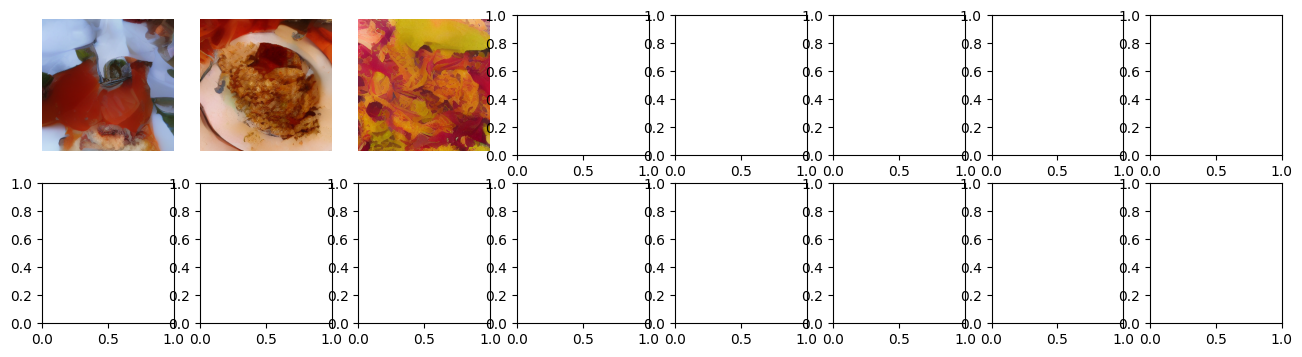

In [14]:
# Check for existing checkpoints and resume if available
latest_checkpoint = find_latest_checkpoint(config.output_dir)

# Train the model (will resume from checkpoint if found)
batch_losses, epoch_losses = train(
    config, vae, unet, dataloader, device, 
    resume_from_checkpoint=latest_checkpoint
)

## 12. Visualize Training Loss

In [ ]:
def plot_losses(batch_losses: List[float], epoch_losses: List[float], output_dir: str = None):
    """Generate and save loss plots for per-batch and per-epoch losses."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(batch_losses, linewidth=0.8, alpha=0.7)
    axes[0].set_xlabel("Batch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training Loss per Batch")
    axes[0].grid(True, alpha=0.3)

    if len(epoch_losses) > 0:
        axes[1].plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linewidth=2)
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Average Loss")
        axes[1].set_title("Training Loss per Epoch")
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    
    if output_dir:
        loss_plot_path = os.path.join(output_dir, "training_loss.png")
        plt.savefig(loss_plot_path, dpi=150)
        print(f"Loss plots saved to {loss_plot_path}")
    
    plt.show()


# Plot the losses
plot_losses(batch_losses, epoch_losses, config.output_dir)

## 13. Unconditional Sampling Function

In [ ]:
@torch.no_grad()
def sample(
    num_inference_steps: int = 50,
    seed: Optional[int] = None,
):
    """Generate an image unconditionally."""
    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    latents = torch.randn((1, 4, config.image_size // 8, config.image_size // 8), device=device)

    unet.eval()
    for t in tqdm(scheduler.timesteps, desc="Sampling"):
        latent_model_input = scheduler.scale_model_input(latents, t)
        noise_pred = unet(latent_model_input, t).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    latents = latents / 0.18215
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu()

    return image

## 14. Generate Sample Images

In [ ]:
# Generate multiple random ImageNet samples
num_samples = 16
num_inference_steps = 50

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    print(f"Generating sample {i+1}/{num_samples}")
    generated_image = sample(
        num_inference_steps=num_inference_steps,
        seed=42 + i,
    )
    
    img = generated_image[0].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')

plt.suptitle("Generated ImageNet Samples (Unconditional)", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, "generated_samples.png"), dpi=150)
plt.show()

## 15. Save Individual Sample

In [ ]:
from torchvision.utils import save_image

print("Generating single ImageNet sample...")

generated_image = sample(
    num_inference_steps=50,
    seed=42,
)

output_path = os.path.join(config.output_dir, "sample_imagenet.png")
save_image(generated_image, output_path)
print(f"Sample saved to: {output_path}")

plt.figure(figsize=(6, 6))
img = generated_image[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title("Generated ImageNet Sample")
plt.axis('off')
plt.show()